# Analysis and visualization of Micrmonas psr1-like gene in TARA Oceans metatranscriptomic data from protist size classes

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks")

%matplotlib inline


## Read in data from supplemental text and Pangea

In [2]:
#Supplemental data table from Euk paper 
ref_data = pd.read_excel('input/41467_2017_2342_MOESM10_ESM.xlsx', header=1)
#Pangea data table detailing sample information for each Tara Station
pangea = pd.read_table('input/PANGAEA.842237.TARAStations.txt')
#subset lat lon
lat_lon = pangea.set_index('Station')[['Latitude','Longitude']]

#leading zeros are differen't between the two datasets :p
new_stations=[]
for i in ref_data.Stations.str.split('_'):
    newName = i[0]+'_'+str(i[1]).zfill(3)
    new_stations.append(newName)
ref_data['NewStation']=new_stations
ref_data_clean = ref_data[['Tara Oceans ID', 'BioSamples ID', 'Stations', 'Depth','Filter', 'Sample Code', 'NewStation']]

# load in the total reads for all reads that are micromonas
all_micro_metaT = pd.read_csv('input/metaT-micromonas-ALL.csv')

#sum to get the FPKM abundance of micrmonas by sample 
summed_micro_abund = all_micro_metaT.groupby('sampleCode').sum()['Occurrence']

all_samples_metaT = pd.read_csv('input/sample_abundance.tsv', index_col=0)

proportion_micro_metaT = pd.DataFrame(summed_micro_abund)/all_samples_metaT

## Load gene tables and lists for psr1, citrate kinase, fumarase, etc. 

In [3]:
psr1_hits = pd.read_table('input/psr1-hit-list.tab', header=None)
psr1_hits = set(list(psr1_hits[0]))
micro_psr1 = list(set(all_micro_metaT.unigeneID).intersection(psr1_hits))
psr1 = pd.Series(micro_psr1)
citrate_synth = pd.read_csv('input/Micromonas_matches_from_Tara_CitrateSynth.csv').V1
citrate_synth = citrate_synth.rename('citrate_synth')
fumarase_synth = pd.read_csv('input/Micromonas_matches_from_Tara_Fumarase.csv').V1
fumarase_synth = fumarase_synth.rename('fumarase')
pyrkinase = pd.read_csv('input/Micromonas_matches_from_Tara_PyrKinase.csv').V1
pyrkinase = pyrkinase.rename('Pyr_kinase')


## Create a data frame with our genes of interest

In [4]:
geneDict = {'PSR1': psr1, 'fumarase': fumarase_synth, 'citrate_synth': citrate_synth, 'pyrkinase': pyrkinase}

micromonas_genes_normalized_df = pd.DataFrame(summed_micro_abund)
micromonas_genes_normalized_df.columns = ['micromonas_occurence']
micromonas_genes_normalized_df['micromonas_occurence_proportion'] = proportion_micro_metaT

for key in geneDict: 
    tmp = all_micro_metaT.set_index('unigeneID').loc[geneDict[key]].reset_index().pivot_table(values='Occurrence',
                    index='sampleCode', columns='unigeneID').fillna(0).sum(axis=1)
    test = tmp/summed_micro_abund
    test = test.fillna(0)
    micromonas_genes_normalized_df[key+'_normalized'] = test

# merge with environmental data    
stat_sum_details = ref_data_clean.merge(micromonas_genes_normalized_df, left_on='Sample Code', right_index=True).set_index('Tara Oceans ID')

#Include the other information-- e.g. Tara Oceans ID
ref_data_clean2 = ref_data_clean.drop('Sample Code', axis = 1).drop_duplicates()
stat_sum_details = stat_sum_details.merge(lat_lon, left_on='NewStation', right_index=True)
stat_sum_details.head()

/vortexfs1/home/halexander/.conda/envs/basemaptest/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,BioSamples ID,Stations,Depth,Filter,Sample Code,NewStation,micromonas_occurence,micromonas_occurence_proportion,PSR1_normalized,fumarase_normalized,citrate_synth_normalized,pyrkinase_normalized,Latitude,Longitude
Tara Oceans ID,,,,,,,,,,,,,,
TARA_N000001610,SAMEA2622130,TARA_100,DCM,0.8 - 5,100DCM1GGMM14,TARA_100,3.890315e-08,0.000019,0.0,0.0,0.0,0.000000,-13.162,-96.283
TARA_N000001606,SAMEA2622128,TARA_100,DCM,0.8 - 2000,100DCM1GGZZ14,TARA_100,6.118218e-08,0.000030,0.0,0.0,0.0,0.000000,-13.162,-96.283
TARA_N000001614,SAMEA2622132,TARA_100,DCM,5 - 20,100DCM1MMQQ14,TARA_100,5.973129e-08,0.000021,0.0,0.0,0.0,0.005474,-13.162,-96.283
TARA_N000001618,SAMEA2657077,TARA_100,DCM,20 - 180,100DCM1QQSS14,TARA_100,4.988928e-08,0.000017,0.0,0.0,0.0,0.000000,-13.162,-96.283
TARA_N000001622,SAMEA2657044,TARA_100,DCM,180 - 2000,100DCM1SSUU14,TARA_100,6.825721e-09,0.000005,0.0,0.0,0.0,0.000000,-13.162,-96.283


## Add total micromonas occurance and normaized occurance; normalize gene set values to total micromonas occurance per sample

In [5]:
geneList_normalized = [item + '_normalized' for item in list(geneDict.keys())]
geneList_normalized.append('micromonas_occurence')
geneList_normalized.append('micromonas_occurence_proportion')
summed_Stat_Depth = stat_sum_details.groupby(['NewStation', 'Depth', 'Latitude', 'Longitude'])[geneList_normalized].sum().reset_index()
depthHash = {}
for depth in ['SRF','DCM', 'MES']:
    df=summed_Stat_Depth[summed_Stat_Depth.Depth==depth]
    depthHash[depth]=df


## Create a function to facilitate the plotting of scaled scatters on a world map. 

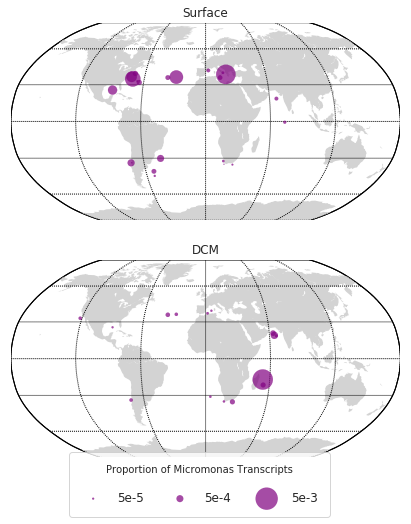

In [6]:
import matplotlib.colors as colors
pal = sns.light_palette("purple", as_cmap=True)

def plot_distribution(inDF, ax = None, column = 'micromonas_occurance_proportion', 
                      scale = 10**5, alpha =1, color = False, c='b',location=False):
    m = Basemap(projection='robin',lon_0=0,resolution='c', ax = ax)
    m.drawcoastlines( linewidth=0)
    m.fillcontinents(color='lightgray',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,90.,30), labels = [])
    m.drawmeridians(np.arange(0.,360.,60.))
    m.drawmapboundary(fill_color='white')
    lats = list(inDF['Latitude'])
    lons = list(inDF['Longitude'])
    size = inDF[column]* scale
    x, y = m(lons, lats)
    norm=colors.LogNorm(vmin=1e-5, vmax=0.1)
    if color == True: #vary color with colormap based on passed variable-- size constant
        sc = m.scatter(x,y, lw=0, s=100, c=inDF[column], cmap = pal, norm=norm, alpha = alpha, zorder=10)
    elif location==True:
        m.scatter(x,y, lw=0, s=5, color = c, norm=norm, alpha = alpha,zorder=10)
        sc=0
    else:
        m.scatter(x,y, lw=0.2, s=size, color = c, alpha = alpha, zorder=10)
        sc=0
    return(m, sc)

fig, axs =plt.subplots(2,1, figsize = [8,8])

# Create some sizes and some labels.

color='purple'
scale=10**5
alpha=0.7

plot_distribution(depthHash['SRF'], axs[0], 'PSR1_normalized',color = False, alpha=alpha, c=color)
plot_distribution(depthHash['DCM'], axs[1], 'PSR1_normalized',color = False, alpha=alpha, c=color)
axs[0].set_title('Surface')
axs[1].set_title('DCM')

#legend

l1 = axs[1].scatter([],[], s=0.00005*scale, edgecolors='none', color=color, alpha=alpha)
l2 = axs[1].scatter([],[], s=0.0005*scale, edgecolors='none', color=color, alpha=alpha)
l3 = axs[1].scatter([],[], s=0.005*scale, edgecolors='none', color=color, alpha=alpha)


labels = ["5e-5", "5e-4", "5e-3"]

leg = plt.legend([l1, l2, l3], labels, ncol=3, frameon=True, fontsize=12, handlelength=2, loc = [0.15,-0.3], 
                 borderpad = 1, handletextpad=1, title='Proportion of Micromonas Transcripts\n',scatterpoints = 1)

fig.savefig('output/Micrmonas_PSR1_disbrituion_percentTranscript.pdf', bbox_inches='tight')


## Create a scatter plot comparing PO4 concentrations, Micromonas abundance, and PSR1 expression. 


/vortexfs1/home/halexander/.conda/envs/basemaptest/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


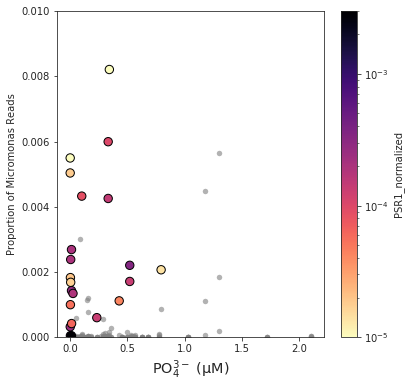

In [7]:

env = pd.read_csv('input/environmental_parameters.csv', sep='\t')
env_merged = stat_sum_details.merge(env, left_on='BioSamples ID', right_on= 'BioSamples_ID')

fig,ax = plt.subplots(1, figsize = [6,6])
y='micromonas_occurence_proportion'
x = 'PO4 (µmol/l)'

dgrp = env_merged.groupby('Depth')

for n, g in dgrp:
    if n=='SRF':
        df = g[env_merged[x]>0]
        pdf = df[df.PSR1_normalized>0]
        ndf = df[df.PSR1_normalized==0]
        
        norm=colors.LogNorm(vmin=1e-5, vmax=0.003)
        #plot greater than cut off
        pdf.plot(kind='scatter', x=x, y=y, ax =ax, lw = 1, 
                c='PSR1_normalized', label = 'PSR1_noramlized', s=70,
                 cmap='magma_r', norm=norm, edgecolor = 'k', legend=False)
        
        ndf.plot(kind='scatter', x=x, y=y, ax =ax, lw = 0, 
                color='gray', label = 'PSR1_noramlized', s=30, alpha = 0.6, zorder = 0, legend =False)
        ax.set_xlabel(r'PO$_4^{3-}$ (µM)', fontsize='x-large')
        ax.set_ylabel("Proportion of Micromonas Reads")
        ax.set_ylim([0,0.01])
fig.savefig('output/PO4_Abundance_PSR1_scatter.pdf', bbox_inches='tight')

## Create a series of violin plots to assess the expression differences in Carbon related genes with and without PSR1 also detected

In [8]:
#get just the gene values
env_merged2 = env_merged.copy()
env_merged2=env_merged2.set_index('Sample Code')
genes_only = env_merged2[geneList_normalized]
genes_only=genes_only.drop(['micromonas_occurence', 'micromonas_occurence_proportion'],axis=1)
genes_only = genes_only[genes_only.sum(axis=1)>0]
genes_only['PSR1_presence'] = 'Absent'
genes_only['PSR1_presence'].loc[genes_only.PSR1_normalized!=0]='Present'

#group by presence/absence of PSR1
PSR1_presence = genes_only.PSR1_presence
C_genes_only = genes_only.drop(['PSR1_normalized','PSR1_presence'], axis=1)


Cgene_only_unstacked = pd.DataFrame(C_genes_only.unstack()).reset_index().set_index('Sample Code')
Cgene_only_unstacked = Cgene_only_unstacked.merge(pd.DataFrame(PSR1_presence), right_index=True, left_index=True)
Cgene_only_unstacked.columns=['genes', 'occurance', 'PSR1_presence']

/vortexfs1/home/halexander/.conda/envs/basemaptest/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


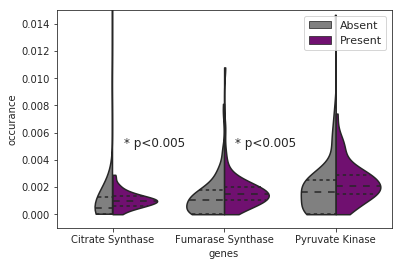

In [9]:
fig,ax = plt.subplots(1, figsize=[6,4])
sns.set(style="whitegrid")
sns.violinplot(x="genes", y="occurance", hue="PSR1_presence",
               split=True, inner="quart",
               palette={"Absent": "grey", "Present": "purple"},
               data=Cgene_only_unstacked, cut =0, legend_out = False, ax = ax)
leg = ax.axes.get_legend()
leg.set_title('PSR1 Presence')
plt.legend(loc='upper right')
ax.text(0.1,0.005, '* p<0.005')
ax.text(1.1,0.005, '* p<0.005')
ax.set_xticklabels(['Citrate Synthase', 'Fumarase Synthase', 'Pyruvate Kinase'])
ax.set_ylim(-0.001, 0.015)
ax.figure.savefig('output/carbon_gene_violin.pdf')



In [10]:
from scipy.stats import ks_2samp

stats ={}
for gene in set(Cgene_only_unstacked.genes):
    tmp = Cgene_only_unstacked[Cgene_only_unstacked.genes==gene]
    pres = tmp[tmp.PSR1_presence=='Present'].occurance
    absent = tmp[tmp.PSR1_presence=='Absent'].occurance
    res = ks_2samp(pres, absent)
    stats[gene]=res
stats

{'citrate_synth_normalized': Ks_2sampResult(statistic=0.3192982456140351, pvalue=0.0009960226923927775),
 'pyrkinase_normalized': Ks_2sampResult(statistic=0.25263157894736843, pvalue=0.017118432527856352),
 'fumarase_normalized': Ks_2sampResult(statistic=0.41754385964912283, pvalue=4.498975851690933e-06)}

## Combine all the plots

/vortexfs1/home/halexander/.conda/envs/basemaptest/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


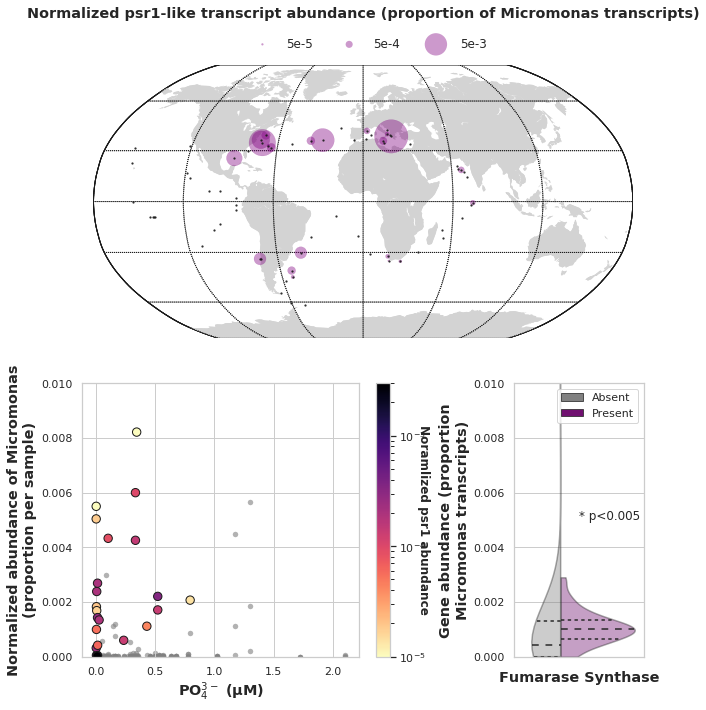

In [11]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = [10,10])
gs = gridspec.GridSpec(4, 6)
ax1 = fig.add_subplot(gs[0:2, 0:])
ax2 = fig.add_subplot(gs[2:, 0:4])
ax3 = fig.add_subplot(gs[2:, 4:])

color = 'purple'
#plot map

alpha = 0.4
plot_distribution(depthHash['SRF'], ax1, 'PSR1_normalized',color = False, 
                  alpha=alpha, c=color, scale = 3* 10**5)
plot_distribution(depthHash['SRF'], ax1, 'micromonas_occurence_proportion',color = False, 
                  alpha=0.9, c='k', scale=1, location=True)

l1 = axs[1].scatter([],[], s=0.00005*scale, edgecolors='none', color=color, alpha=alpha)
l2 = axs[1].scatter([],[], s=0.0005*scale, edgecolors='none', color=color, alpha=alpha)
l3 = axs[1].scatter([],[], s=0.005*scale, edgecolors='none', color=color, alpha=alpha)


labels = ["5e-5", "5e-4", "5e-3"]
leg = ax1.legend([l1, l2, l3], labels, ncol=3, frameon=False, fontsize=12, handlelength=2, loc = [0.28,1.03], 
                 borderpad = 0.5, handletextpad=1,
                 scatterpoints = 1)

ax1.set_title('Normalized psr1-like transcript abundance (proportion of Micromonas transcripts)', 
              fontsize='large', weight='bold', position=[0.5, 1.15])


# plot scatter of PO4 vs micromonas occurance proportion

y='micromonas_occurence_proportion'
x = 'PO4 (µmol/l)'

dgrp = env_merged.groupby('Depth')

for n, g in dgrp:
    if n=='SRF':
        df = g[env_merged[x]>0]
        pdf = df[df.PSR1_normalized>0]
        ndf = df[df.PSR1_normalized==0]
        
        norm=colors.LogNorm(vmin=1e-5, vmax=0.003)
        #plot greater than cut off
        pdf.plot(kind='scatter', x=x, y=y, ax =ax2, lw = 1, 
                c='PSR1_normalized', label = 'Noramlized psr1 abundance', s=70,
                 cmap='magma_r', norm=norm, edgecolor = 'k', legend=False, )
        
        ndf.plot(kind='scatter', x=x, y=y, ax =ax2, lw = 0, 
                color='gray', label = 'PSR1_noramlized', s=30, alpha = 0.6, zorder = 0, legend =False)
        ax2.set_xlabel(r'PO$_4^{3-}$ (µM)', fontsize='large', weight='bold')
        ax2.set_ylabel("Normalized abundance of Micromonas\n(proportion per sample)", weight='bold', size='large')
        ax2.set_ylim([0,0.01])
cax = fig.get_axes()[3]    
cax.set_ylabel('Noramlized psr1 abundance', rotation = 270, weight='bold')
        
ax = sns.violinplot(x="genes", y="occurance", hue="PSR1_presence",
               split=True, inner="quart",
               palette={"Absent": "gray", "Present": color},
               data=Cgene_only_unstacked[Cgene_only_unstacked.genes=='fumarase_normalized']
                    , cut =0, legend_out = False, ax = ax3, alpha=0.4, )
plt.setp(ax.collections, alpha=.4)
ax.set_ylabel('Gene abundance (proportion\nMicromonas transcripts)', weight='bold', fontsize='large')

leg = ax.axes.get_legend()
leg.set_title('PSR1 Presence')
plt.legend(loc='upper right')
ax.text(0.1,0.005, '* p<0.005')
# ax.text(1.1,0.005, '* p<0.005')
ax.set_xticklabels([''])

ax.set_xlabel('Fumarase Synthase', fontsize='large', weight='bold')
ax.set_ylim(0, 0.01)
ax.set_xlim(-.25, 0.45)


fig.tight_layout()

fig.savefig('output/Figure6_Tara.pdf', bbox_inches='tight')
